# Imports

In [122]:
import numpy as np
import roboticstoolbox as rtb
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

# Utils

In [123]:
def fkine_planar(q, l1=1.0, l2=1.0):
    q1, q2 = q
    x0, y0 = 0, 0
    x1 = l1 * np.cos(q1)
    y1 = l1 * np.sin(q1)
    x2 = x1 + l2 * np.cos(q1 + q2)
    y2 = y1 + l2 * np.sin(q1 + q2)
    return np.array([[x0, y0], [x1, y1], [x2, y2]])

def generar_video_trayectoria(tg_q, nombre_archivo='robot_trajectory.mp4',
                              export_fps=60, sim_dt=1e-3,
                              l1=1.0, l2=1.0):
    """
    Genera un video animado de la trayectoria de un robot planar de 2 DOF.
    
    Parámetros:
        tg_q           : np.ndarray de forma (N, 2) con las configuraciones articulares
        nombre_archivo : str, nombre del archivo de salida (formato .mp4)
        export_fps     : int, cuadros por segundo del video
        sim_dt         : float, paso de integración usado en la simulación
        l1, l2         : float, longitudes de los eslabones del robot
    """
    skip = int(1 / (export_fps * sim_dt))

    fig, ax = plt.subplots()
    line, = ax.plot([], [], 'o-', lw=4)
    ax.set_xlim(-l1 - l2 - 0.5, l1 + l2 + 0.5)
    ax.set_ylim(-l1 - l2 - 0.5, l1 + l2 + 0.5)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title("Animación de trayectoria del robot")

    def init():
        line.set_data([], [])
        return line,

    def update(i):
        q = tg_q[i]
        points = fkine_planar(q, l1, l2)
        line.set_data(points[:, 0], points[:, 1])
        return line,

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(0, len(tg_q), skip),
        init_func=init,
        blit=True,
        interval=1000 / export_fps
    )

    ani.save(nombre_archivo, writer='ffmpeg', fps=export_fps)
    print(f"✅ Video guardado como '{nombre_archivo}'")

def generar_video_trayectoria(tg_q, nombre_archivo='robot_trajectory.mp4',
                              export_fps=60, sim_dt=1e-3,
                              l1=1.0, l2=1.0):
    """
    Genera un video animado de la trayectoria de un robot planar de 2 DOF,
    incluyendo una traza del extremo del péndulo.

    Parámetros:
        tg_q           : np.ndarray de forma (N, 2) con las configuraciones articulares
        nombre_archivo : str, nombre del archivo de salida (formato .mp4)
        export_fps     : int, cuadros por segundo del video
        sim_dt         : float, paso de integración usado en la simulación
        l1, l2         : float, longitudes de los eslabones del robot
    """
    skip = int(1 / (export_fps * sim_dt))
    
    fig, ax = plt.subplots()
    line, = ax.plot([], [], 'o-', lw=4, label='Robot')
    trace_line, = ax.plot([], [], 'r--', lw=1.5, alpha=0.7, label='Traza')
    
    ax.set_xlim(-l1 - l2 - 0.5, l1 + l2 + 0.5)
    ax.set_ylim(-l1 - l2 - 0.5, l1 + l2 + 0.5)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title("Animación de trayectoria del robot")
    ax.legend()

    trace_x = []
    trace_y = []

    def init():
        line.set_data([], [])
        trace_line.set_data([], [])
        return line, trace_line

    def update(i):
        q = tg_q[i]
        points = fkine_planar(q, l1, l2)

        # Actualiza el robot
        line.set_data(points[:, 0], points[:, 1])
        
        # Agrega la nueva posición del extremo
        trace_x.append(points[-1, 0])
        trace_y.append(points[-1, 1])
        trace_line.set_data(trace_x, trace_y)
        
        return line, trace_line

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(0, len(tg_q), skip),
        init_func=init,
        blit=True,
        interval=1000 / export_fps
    )

    ani.save(nombre_archivo, writer='ffmpeg', fps=export_fps)
    print(f"✅ Video guardado como '{nombre_archivo}'")

def generar_escalon_suave(T_total, Ts, t_subida, ref_value, q0=0.0):
    """
    Genera una señal escalón con subida lineal desde q0 hasta ref_value.

    Parámetros:
    - T_total   : Tiempo total de la señal [s]
    - Ts        : Tiempo de muestreo [s]
    - t_subida  : Tiempo de subida lineal [s]
    - ref_value : Valor final del escalón
    - q0        : Valor inicial de la señal (por defecto 0.0)

    Retorna:
    - t   : Vector de tiempo
    - u   : Señal del escalón suavizado
    """
    t = np.arange(0, T_total, Ts)
    u = np.zeros_like(t)

    for i, ti in enumerate(t):
        if ti < t_subida:
            u[i] = q0 + (ref_value - q0) * (ti / t_subida)
        else:
            u[i] = ref_value

    return t, u

def valor_referencia_en_t(t_query, t_subida, ref_value):
    """
    Retorna el valor de la señal escalón suave en el tiempo t_query.

    Parámetros:
    - t_query   : Tiempo en el que se desea conocer el valor [s]
    - t_subida  : Tiempo de subida del escalón [s]
    - ref_value : Valor final del escalón

    Retorna:
    - Valor de la señal en t_query
    """
    if t_query < 0:
        return 0
    elif t_query < t_subida:
        return (ref_value / t_subida) * t_query
    else:
        return ref_value
    
def graficar_dinamica(dp, q, qd, t, q_ref, tau):
    """
    Grafica en una sola figura:
    - Posiciones articulares con sus referencias
    - Velocidades articulares
    - Trayectoria del extremo del robot vs referencia
    - Torques articulares

    Parámetros:
    - dp     : robot DHRobot
    - q      : (n x 2) posiciones articulares en el tiempo
    - qd     : (n x 2) velocidades articulares
    - t      : (n,) vector de tiempo
    - q_ref  : (n x 2) trayectoria articular de referencia
    - tau    : (n x 2) torques articulares en el tiempo
    """

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    
    # 1. Posiciones articulares vs referencia
    axs[0, 0].plot(t, q[:, 0], label='q1', color='blue', linewidth=2)
    axs[0, 0].plot(t, q[:, 1], label='q2', color='orange', linewidth=2)
    axs[0, 0].plot(t, q_ref[:, 0], '--', label='q1 ref', color='blue', alpha=0.5, linewidth=2)
    axs[0, 0].plot(t, q_ref[:, 1], '--', label='q2 ref', color='orange', alpha=0.5, linewidth=2)
    axs[0, 0].set_title('Posiciones articulares')
    axs[0, 0].set_xlabel('Tiempo [s]')
    axs[0, 0].set_ylabel('Ángulo [rad]')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # 2. Velocidades articulares
    axs[0, 1].plot(t, qd[:, 0], label='qd1', color='blue', linewidth=2)
    axs[0, 1].plot(t, qd[:, 1], label='qd2', color='orange', linewidth=2)
    axs[0, 1].set_title('Velocidades articulares')
    axs[0, 1].set_xlabel('Tiempo [s]')
    axs[0, 1].set_ylabel('Velocidad [rad/s]')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # 3. Trayectoria cartesiana
    x_real, y_real = [], []
    x_ref, y_ref = [], []
    for qi, qi_ref in zip(q, q_ref):
        T_real = dp.fkine(qi)
        T_ref = dp.fkine(qi_ref)
        x_real.append(T_real.t[0])
        y_real.append(T_real.t[1])
        x_ref.append(T_ref.t[0])
        y_ref.append(T_ref.t[1])

    axs[1, 0].plot(x_real, y_real, label='Trayectoria real', color='green', linewidth=2)
    axs[1, 0].plot(x_ref, y_ref, '--', label='Trayectoria ref', color='red', linewidth=2)
    axs[1, 0].set_title('Trayectoria del extremo del péndulo')
    axs[1, 0].set_xlabel('X [m]')
    axs[1, 0].set_ylabel('Y [m]')
    axs[1, 0].axis('equal')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # 4. Torques articulares
    axs[1, 1].plot(t, tau[:, 0], label='τ1', color='blue', linewidth=2)
    axs[1, 1].plot(t, tau[:, 1], label='τ2', color='orange', linewidth=2)
    axs[1, 1].set_title('Torques articulares')
    axs[1, 1].set_xlabel('Tiempo [s]')
    axs[1, 1].set_ylabel('Torque [Nm]')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


# Double Pendulum Model:

In [124]:
import roboticstoolbox as rtb
import numpy as np

# === Parámetros físicos del robot ===
l1 = 0.2      # Longitud del primer eslabón [m]
m1 = 1.5      # Masa del primer eslabón [kg]

l2 = 0.2      # Longitud del segundo eslabón [m]
m2 = 1.0      # Masa del segundo eslabón [kg]

# === Definición del robot usando el modelo de Denavit-Hartenberg (DH) ===
dp = rtb.DHRobot(
    [
        # Primer eslabón (Revolute Joint)
        rtb.RevoluteDH(
            a=l1,                    # Longitud del eslabón (DH)
            m=m1,                   # Masa del eslabón [kg]
            r=np.array([-0.1, 0, 0]),  # Centro de masa relativo al frame del eslabón
            I=np.array([0, 0, 0, 0, 0, 0, 0, 0, 1e-3]),  # Tensor de inercia 
            B=0.01,                  # Fricción viscosa [Nm/(rad/s)]
            G=1                    # Ganancia de transmisión (sin reductor)
        ),
        
        # Segundo eslabón (Revolute Joint)
        rtb.RevoluteDH(
            a=l2,
            m=m2,
            r=np.array([-0.1, 0, 0]),
            I=np.array([0, 0, 0, 0, 0, 0, 0, 0, 1e-4]),
            B=0.001,
            G=1
        )
    ],
    gravity=np.array([0, -9.8, 0]),  # Vector de gravedad (en dirección -y)
    name="dp"                        # Nombre del robot
)

# === Mostrar el modelo del robot ===
print(dp)

# === Mostrar parámetros dinámicos del modelo ===
print(dp.dynamics())


DHRobot: dp, 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬─────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├─────┼────┼─────┼──────┤
│  q1 │  0 │ 0.2 │ 0.0° │
│  q2 │  0 │ 0.2 │ 0.0° │
└─────┴────┴─────┴──────┘

┌──┬──┐
└──┴──┘

┌───────┬──────┬──────────────┬─────────────────────────────┬────┬────────┬────────┬────┐
│   j   │  m   │      r       │              I              │ Jm │   B    │   Tc   │ G  │
├───────┼──────┼──────────────┼─────────────────────────────┼────┼────────┼────────┼────┤
│ link1 │  1.5 │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0  │  0 │  0.01  │  0,  0 │  1 │
│ link2 │  1   │ -0.1,  0,  0 │  0,  0,  0.0001,  0,  0,  0 │  0 │  0.001 │  0,  0 │  1 │
└───────┴──────┴──────────────┴─────────────────────────────┴────┴────────┴────────┴────┘

None


# Ejercicio 1

## Simulación de la dinámica de un robot planar de 2 DOF

## Objetivo:

Implementar un simulador de dinámica directa para un robot planar de dos grados de libertad (DOF), y evaluar su comportamiento dinámico bajo diferentes condiciones iniciales y entradas de torque. El propósito es analizar características clave del sistema, como:

- Estabilidad e inestabilidad en puntos de equilibrio.
- Comportamiento caótico (sensibilidad a condiciones iniciales).
- Respuesta ante torques externos constantes.

La simulación no considera fricción viscosa y de Coulomb, y se realiza mediante integración numérica hacia adelante.

---

## Pruebas Realizadas

### **Test 1: Condición inicial nula**
- `q0 = [0, 0]`
- Sin torque externo.
- Resultado: se observa una trayectoria definida por el sistema con fricción, donde el robot tiende a estabilizarse.

###  **Test 2: Perturbación mínima en q0**
- `q0 = [-0.01, 0]`
- Resultado: pese al cambio ínfimo en la condición inicial, la trayectoria se desvía significativamente respecto a Test 1.  
- **Conclusión**: evidencia de comportamiento caótico.

### **Test 3: Punto de equilibrio estable**
- `q0 = [-π/2, 0]` (ambos eslabones colgando hacia abajo)
- Resultado: el sistema permanece cerca de la posición inicial, disipando movimiento gracias a la fricción.
- **Conclusión**: punto de equilibrio estable.

### **Test 4: Punto de equilibrio inestable**
- `q0 = [π/2, 0]` (eslabón 1 apuntando hacia arriba)
- Resultado: cualquier pequeña perturbación, como la producida por el ruido numerico, genera una caída hacia el equilibrio estable.
- **Conclusión**: configuración inestable.

### **Test 5: Torque constante**
- `Q = lambda *args: np.array([3, 3])`
- Resultado: el robot se acelera de forma progresiva debido al torque externo constante.
- **Conclusión**: se valida que el sistema responde adecuadamente ante excitaciones externas.

---

## ✅ Conclusiones Generales

- El simulador responde de forma coherente ante condiciones iniciales y entradas externas.
- Se evidencia comportamiento caótico.
- Las condiciones de equilibrio se comportan como se esperaría: el equilibrio estable retiene al sistema, el inestable no.

## Simulaciones sin rozamiento

✅ Video guardado como 'trayectoria_test1_NoB.mp4'
✅ Video guardado como 'trayectoria_test2_NoB.mp4'
✅ Video guardado como 'trayectoria_test3_NoB.mp4'
✅ Video guardado como 'trayectoria_test4_NoB.mp4'


RuntimeError: integration completed with failed status 

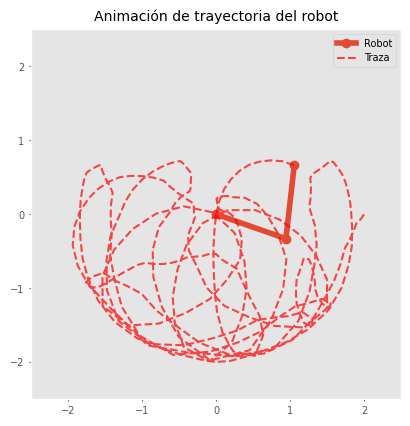

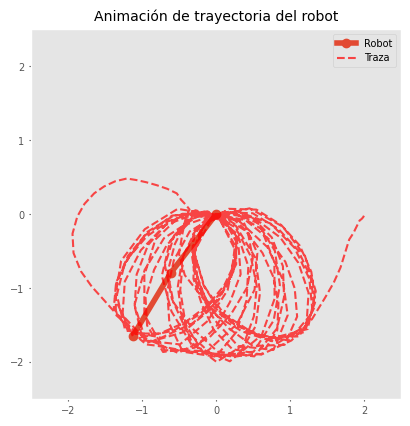

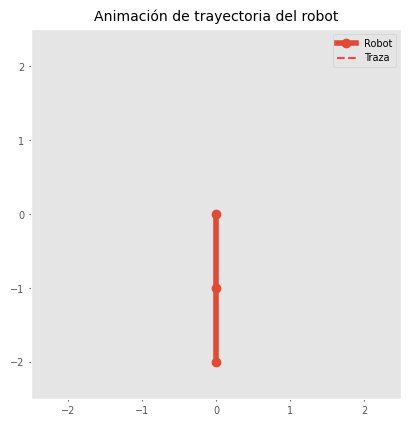

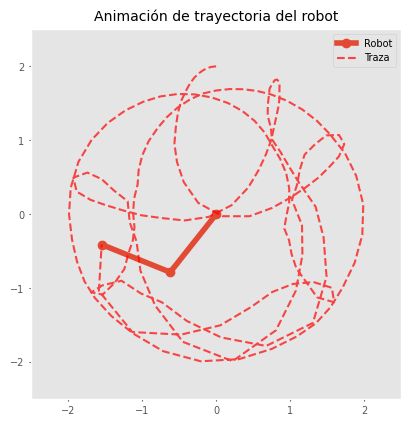

In [ ]:
# Simulación de dinámica directa del robot sin fricción (con fricción Coulomb y viscosa activadas),
# utilizando integración numérica hacia adelante durante 5 segundos.

# Parámetros de la función fdyn:
# T : duración total de la simulación (en segundos)
# q0 : posición inicial de las articulaciones
# Q: función que devuelve el torque (torque aplicado a las articulaciones)
# qd0:  velocidad inicial de las articulaciones (en este caso, ambas en 0)
# dt: paso de integración (1 ms)

# Retorna un objeto trayectoria con los siguientes campos:
# - t: vector de tiempos
# - q: posiciones articulares en cada paso de tiempo
# - qd: velocidades articulares en cada paso de tiempo


# =============================
# Simulaciones de dinámica directa de un robot planar de 2 DOF
# con fricción viscosa y de Coulomb, usando integración numérica.
# =============================

# Cada prueba ejecuta una simulación por 5 segundos, con paso de integración de 1 ms,
# utilizando diferentes condiciones iniciales para analizar estabilidad y caos.

# Cambio l1 y l2 para los graficos:
l1 = 1
l2 = 1

# -----------------------------------------------------------
# Test 1: Sensibilidad a condiciones iniciales - Caso base
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=True).fdyn(
    T=5,
    q0=[0, 0],
    Q=None,  # Sin torque aplicado
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test1_NoB.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 2: Sensibilidad a condiciones iniciales - Cambio leve en q0
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=True).fdyn(
    T=5,
    q0=[-0.01, 0],  # Cambio mínimo en posición inicial
    Q=None,
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test2_NoB.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 3: Equilibrio estable (pendulo vertical hacia abajo)
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=True).fdyn(
    T=5,
    q0=[-np.pi/2, 0],
    Q=None,
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test3_NoB.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 4: Equilibrio inestable (pendulo vertical hacia arriba)
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=True).fdyn(
    T=5,
    q0=[np.pi/2, 0],
    Q=None,
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test4_NoB.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 5: Aplicación de torque constante (externo)
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=True).fdyn(
    T=5,
    q0=[-np.pi/2, 0],
    Q=lambda *args: np.array([2, 2]),  # Torque constante positivo en ambas articulaciones
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test5_NoB.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)


## Simulaciones con rozamiento

✅ Video guardado como 'trayectoria_test1_B.mp4'
✅ Video guardado como 'trayectoria_test2_B.mp4'
✅ Video guardado como 'trayectoria_test3_B.mp4'
✅ Video guardado como 'trayectoria_test4_B.mp4'


RuntimeError: integration completed with failed status 

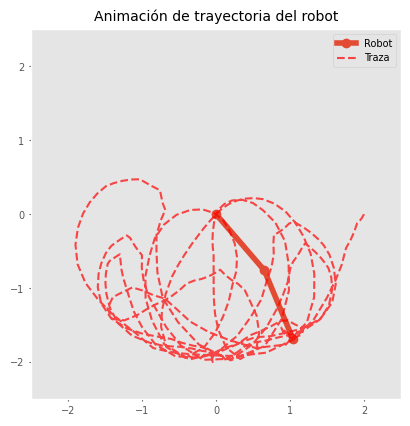

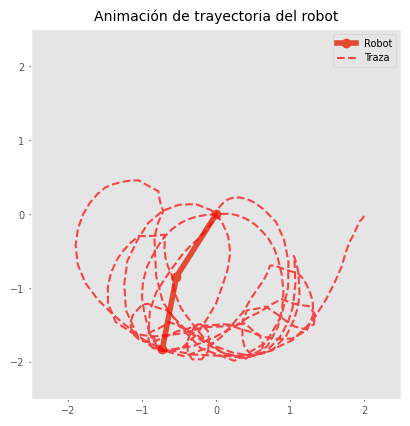

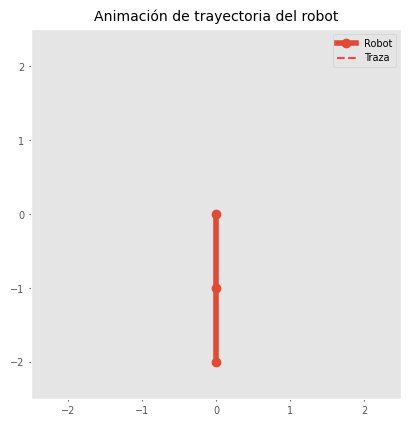

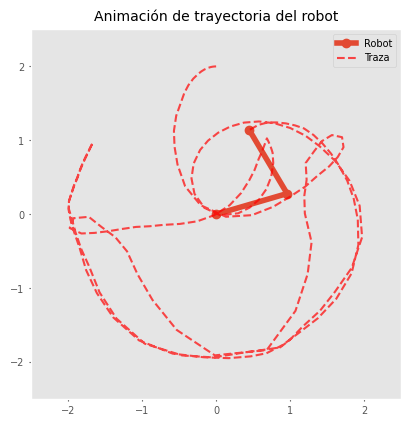

In [27]:
# Simulación de dinámica directa del robot sin fricción (con fricción Coulomb y viscosa activadas),
# utilizando integración numérica hacia adelante durante 5 segundos.

# Parámetros de la función fdyn:
# T : duración total de la simulación (en segundos)
# q0 : posición inicial de las articulaciones
# Q: función que devuelve el torque (torque aplicado a las articulaciones)
# qd0:  velocidad inicial de las articulaciones (en este caso, ambas en 0)
# dt: paso de integración (1 ms)

# Retorna un objeto trayectoria con los siguientes campos:
# - t: vector de tiempos
# - q: posiciones articulares en cada paso de tiempo
# - qd: velocidades articulares en cada paso de tiempo


# =============================
# Simulaciones de dinámica directa de un robot planar de 2 DOF
# con fricción viscosa y de Coulomb, usando integración numérica.
# =============================

# Cada prueba ejecuta una simulación por 5 segundos, con paso de integración de 1 ms,
# utilizando diferentes condiciones iniciales para analizar estabilidad y caos.

# Cambio l1 y l2 para los graficos:
l1 = 1
l2 = 1

# -----------------------------------------------------------
# Test 1: Sensibilidad a condiciones iniciales - Caso base
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T=5,
    q0=[0, 0],
    Q=None,  # Sin torque aplicado
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test1_B.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 2: Sensibilidad a condiciones iniciales - Cambio leve en q0
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T=5,
    q0=[-0.01, 0],  # Cambio mínimo en posición inicial
    Q=None,
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test2_B.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 3: Equilibrio estable (pendulo vertical hacia abajo)
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T=5,
    q0=[-np.pi/2, 0],
    Q=None,
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test3_B.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 4: Equilibrio inestable (pendulo vertical hacia arriba)
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T=5,
    q0=[np.pi/2, 0],
    Q=None,
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test4_B.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)

# -----------------------------------------------------------
# Test 5: Aplicación de torque constante (externo)
# -----------------------------------------------------------
tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T=5,
    q0=[-np.pi/2, 0],
    Q=lambda *args: np.array([3, 3]),  # Torque constante positivo en ambas articulaciones
    qd0=np.zeros((2,)),
    dt=1e-3
)
generar_video_trayectoria(tg.q, nombre_archivo='trayectoria_test5_B.mp4',
                          export_fps=60, sim_dt=tg.t[1]-tg.t[0], l1=l1, l2=l2)


# Ejercicio 2

## Objetivo

El objetivo principal de este trabajo fue implementar una acción de control que permita no solo el seguimiento preciso de trayectorias de referencia, sino también una adecuada capacidad de rechazo frente a perturbaciones externas, todo esto aplicado a un sistema de péndulo doble. Para ello, se evaluaron dos estrategias de control distintas:

- Un controlador PD clásico, diseñado a partir de un modelo linealizado del sistema.
- Un controlador PD con compensación Feedforward gravitacional (PD+FF), que incorpora un término adicional basado en la dinámica no lineal del sistema.

## Metodología

La implementación comenzó con el diseño de un controlador PD, basado en la linealización del modelo dinámico del péndulo doble. El objetivo del diseño fue lograr un comportamiento críticamente amortiguado, es decir, una respuesta rápida sin oscilaciones, para lo cual se aplicaron criterios de sintonización vistos durante el curso.

Una vez obtenido un desempeño aceptable con el controlador PD, se planteó mejorar el seguimiento en régimen permanente mediante la incorporación de un término de feedforward gravitacional, representado por la matriz \( G(q) \), la cual modela las fuerzas debidas al peso de los brazos del péndulo. El objetivo de esta compensación es neutralizar el efecto de la gravedad, reduciendo así el error de seguimiento en estado estacionario.

## Controlador PD

- Diseñado para cumplir condiciones de amortiguamiento crítico.
- Implementado sobre un modelo linealizado del sistema, lo que simplifica el análisis pero introduce limitaciones ante comportamientos no lineales.
- Sintonizado buscando un compromiso entre rapidez de respuesta y ausencia de sobreoscilaciones.
- Aplica una acción proporcional al error en la posición y una acción derivativa sobre la velocidad angular del sistema.

## Controlador PD + FF

- Conserva la estructura y ganancias del controlador PD.
- Añade un término de compensación gravitacional para contrarrestar las fuerzas internas del sistema:

  \[
  u = -K_p e - K_d \dot{q} + G(q)
  \]

- Este término de feedforward se calcula a partir del modelo dinámico no lineal del péndulo, evaluado sobre la trayectoria de referencia \( q_d \), lo que permite anticipar las fuerzas necesarias para sostener una determinada configuración.

## Resultados de la Simulación

Para evaluar el desempeño de ambos controladores, se realizaron simulaciones del sistema en lazo cerrado bajo diferentes condiciones de referencia y con perturbaciones externas aplicadas a los actuadores:

- Referencias tipo escalón
- Referencias tipo rampa lineal
- Perturbaciones externas (torques impulsivos)

### Observaciones

- **Respuesta ante referencias tipo escalón**:  
  A pesar de haber diseñado el controlador PD para evitar oscilaciones, las simulaciones mostraron la presencia de sobrepicos importantes, lo cual no se ajusta a lo esperado bajo el modelo lineal. Esta discrepancia se atribuye principalmente a dos factores:
  - El carácter abrupto de la entrada escalón, que requiere una acción de control intensa e instantánea.
  - Las no linealidades inherentes del sistema, que no fueron modeladas en el diseño del controlador.

- **Cambio a entrada rampa**:  
  Para mitigar estos efectos no deseados, se reemplazó la entrada escalón por una rampa suave. Esta modificación generó una mejora notable:
  - Reducción del sobrepico en la respuesta.
  - Mejor seguimiento de la trayectoria deseada.
  - Respuesta más predecible y coherente con el modelo de diseño.

- **Desempeño del controlador PD+FF**:  
  Al incorporar el término gravitacional, se logró una reducción considerable del error en régimen permanente. Combinado con una entrada suavizada (rampa), el sistema mostró:
  - Seguimiento más preciso y estable.
  - Mejor seguimiento a configuraciones estáticas alejadas del equilibrio.

- **Rechazo a perturbaciones**:  
  Se introdujeron perturbaciones en forma de impulsos de torque. En ambos casos (PD y PD+FF), el sistema logró recuperar la estabilidad tras la perturbación, aunque no siempre pudo volver exactamente al estado deseado. Esto indica una capacidad razonable de rechazo, aunque limitada por la falta de integralidad o adaptación en el diseño.

## Conclusiones

A partir de las simulaciones y análisis realizados, se pueden extraer las siguientes conclusiones:

- El controlador PD, si bien adecuado para condiciones locales cerca del equilibrio, presenta limitaciones cuando se enfrenta a entradas bruscas o se aleja del régimen lineal. Los sobrepicos observados son consecuencia directa de esta discrepancia entre el modelo de diseño y la realidad del sistema.
- La incorporación del término Feedforward gravitacional es efectiva para mejorar el seguimiento de trayectorias en régimen permanente, especialmente en configuraciones donde las fuerzas internas del sistema tienen un papel relevante.
- El uso de entradas suaves, como rampas en lugar de escalones, resulta fundamental para obtener una respuesta estable y controlada. Esta práctica también reduce la demanda de torque sobre los actuadores, evitando saturaciones y picos no deseados.
- Aunque ambos controladores mostraron cierta capacidad de rechazo a perturbaciones, ninguno logró una recuperación completa del estado original. Esto sugiere la conveniencia de considerar estrategias adicionales, como controladores con acción integral, control robusto o incluso adaptativo, capaces de responder dinámicamente ante variaciones en la dinámica del sistema.

En general, el trabajo muestra cómo una adecuada combinación entre diseño lineal, compensación no lineal y selección cuidadosa de las referencias puede conducir a un control efectivo de sistemas complejos como el péndulo doble.


In [146]:
# -------------------------------------------------------------------
# Parametros Simulacion
# -------------------------------------------------------------------
T = 5                  # T: duración de la simulación en segundos
q0 = [-np.pi/2, 0]            # q0: posición inicial de las articulaciones
qd0=np.zeros((2,))     # qd0: velocidad inicial de las articulaciones
dt=1e-3                # dt: paso de tiempo de integración

# -------------------------------------------------------------------
# Cálculo de mbar: matriz de inercia promedio (diagonalizada)
# -------------------------------------------------------------------
# Se evalúa la matriz de inercia M(q) del robot en una postura
# representativa (q_test = [0, π/2]) que refleja una condición
# de operación típica.
#
# Posteriormente, se aproxima M(q) por una matriz diagonal que
# conserva únicamente los términos m_{11} y m_{22}, eliminando
# los términos de acoplamiento entre articulaciones. Esta
# simplificación se utiliza en el diseño de controladores
# donde se busca reducir la complejidad del modelo dinámico.

q_test = np.array([0, np.pi/2])               # Configuración representativa
mbar_full = dp.inertia(q_test)                # Matriz de inercia completa
mbar = np.array([                            # Aproximación diagonal de M(q)
    [mbar_full[0, 0], 0],
    [0, mbar_full[1, 1]]
])

# -------------------------------------------------------------------
# Parámetros del sistema
# -------------------------------------------------------------------
jm = 0        # Inercia del motor
km = 1        # Constante del motor
N = 1         # Relación de transmisión
wn = 20       # Frecuencia natural deseada (rad/s)
Bef = 0       # Fricción efectiva (puede ajustarse)

# Inercia efectiva en el sistema reflejada al lado del motor
Jef = jm * N**2 + mbar


# Ganancias del controlador (ajustadas según la dinámica simplificada)
kp = (wn**2 * Jef) / (N * km)
kd = (2 * np.sqrt(N * km * kp * Jef) - Bef) / (N * km)


# -------------------------------------------------------------------
# Referencia deseada para la posición articular
# -------------------------------------------------------------------
q_final = np.array([0, 0])
_,q_ref1 = generar_escalon_suave(T,dt,t_subida=0.5,q0=q0[0],ref_value=q_final[0])
_,q_ref2 = generar_escalon_suave(T,dt,t_subida=0.5,q0=q0[1],ref_value=q_final[1])
q_ref = np.vstack((q_ref1,q_ref2)).T


## Control PD:

### Sin perturbacion

✅ Video guardado como 'trayectoria_prueba1_pd-NoP.mp4'


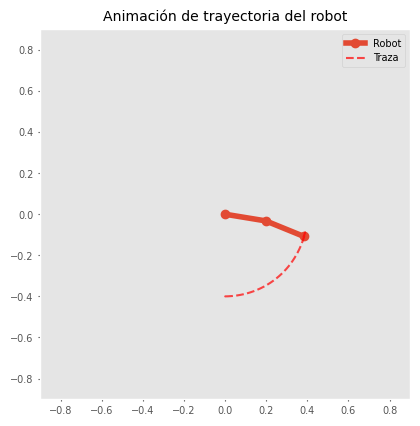

In [ ]:
#--------------------------------------------------------------------
# Torques del controlador
#--------------------------------------------------------------------
Q_vec = np.zeros_like(q_ref)


# -------------------------------------------------------------------
# Controlador PD sin compensación de inercia
# -------------------------------------------------------------------
def pd_control(robot, t, q, qd):
    """
    Controlador PD para seguimiento de trayectoria articular.
    
    Parámetros:
    - robot: objeto robot (no se usa directamente aquí, pero puede ser útil para extensiones)
    - t: tiempo actual (s)
    - q: vector de posiciones articulares actuales
    - qd: vector de velocidades articulares actuales
    
    Retorna:
    - Q: vector de torques de control
    """
    global kp, kd, q_ref

    step = round(t/dt)

    if step >= q_ref.shape[0]:
        step = q_ref.shape[0]-1

    q_ref_i = q_ref[step]


    # Ley de control PD
    Q = np.dot(kp, (q_ref_i - q)) - np.dot(kd, qd)
    return Q

tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T = T,                # T: duración de la simulación en segundos
    q0 = q0,           # q0: posición inicial de las articulaciones
    Q=pd_control,        # Q: función que genera el torque en función del estado
    qd0=qd0,  # qd0: velocidad inicial de las articulaciones
    dt=dt           # dt: paso de tiempo de integración
)

# Calculo de Q (si lo sacabmos de la funcion se bugueaba)
for i in range(q_ref.shape[0]):
    Q_vec[i,:] = pd_control(dp,tg.t[i],tg.q[i],tg.qd[i])


generar_video_trayectoria(tg.q,nombre_archivo='trayectoria_prueba1_pd-NoP.mp4',export_fps=60,sim_dt=tg.t[1]-tg.t[0],l1=l1,l2=l2)

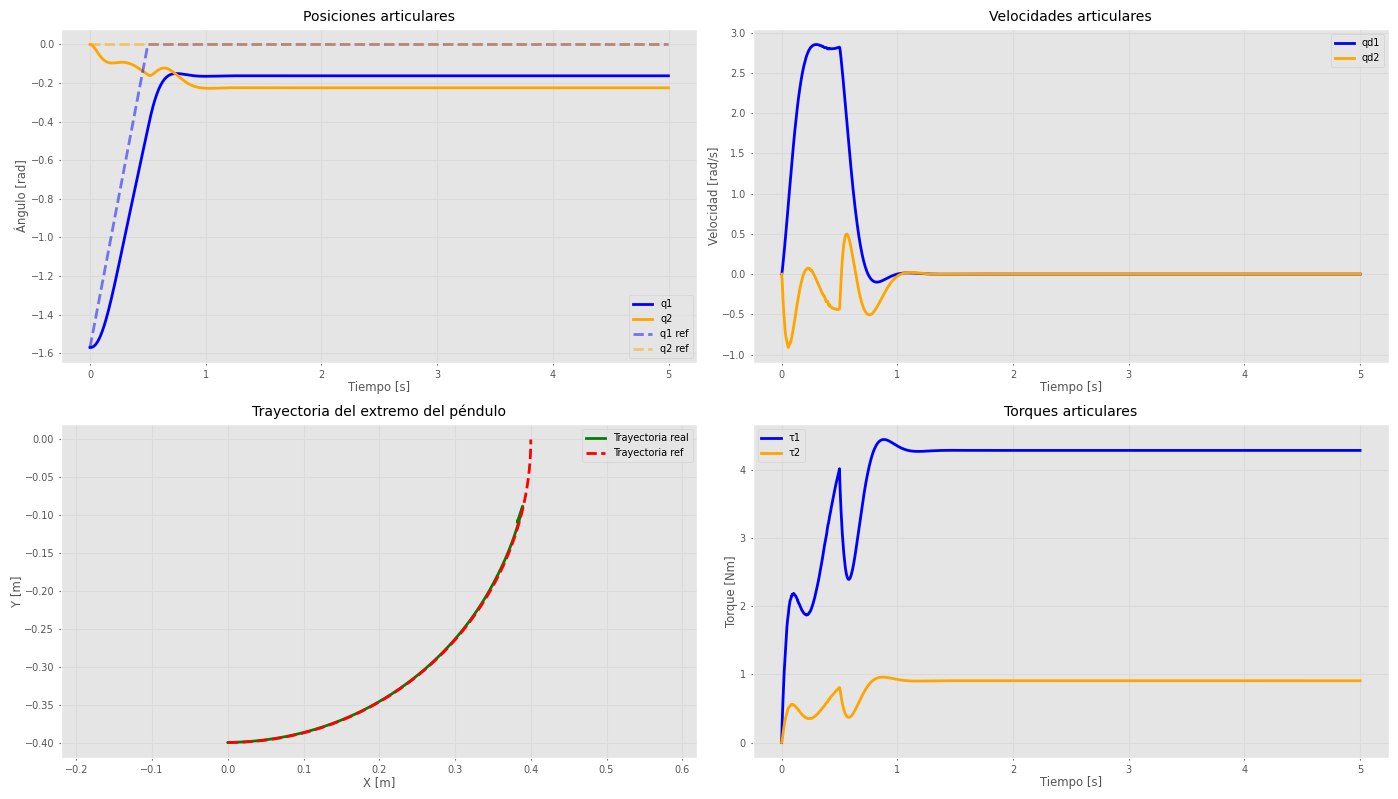

In [149]:
graficar_dinamica(dp,tg.q,tg.qd,tg.t,q_ref,Q_vec)

### Con perturbacion

✅ Video guardado como 'trayectoria_prueba1_pd_P.mp4'


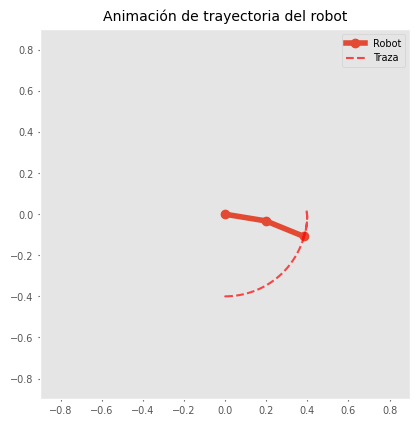

In [ ]:
#--------------------------------------------------------------------
# Torques del controlador
#--------------------------------------------------------------------
Q_vec = np.zeros_like(q_ref)


# -------------------------------------------------------------------
# Controlador PD con compensación de inercia
# -------------------------------------------------------------------
def pd_control_P(robot, t, q, qd):
    """
    Controlador PD para seguimiento de trayectoria articular.
    
    Parámetros:
    - robot: objeto robot (no se usa directamente aquí, pero puede ser útil para extensiones)
    - t: tiempo actual (s)
    - q: vector de posiciones articulares actuales
    - qd: vector de velocidades articulares actuales
    
    Retorna:
    - Q: vector de torques de control
    """
    global kp, kd, q_ref

    step = round(t/dt)

    if step >= q_ref.shape[0]:
        step = q_ref.shape[0]-1

    q_ref_i = q_ref[step]


    # Ganancias del controlador (ajustadas según la dinámica simplificada)
    kp = (wn**2 * Jef) / (N * km)
    kd = (2 * np.sqrt(N * km * kp * Jef) - Bef) / (N * km)

    # Perturbacion:
    tau_p1 = 2 if 3<t<4 else 0
    tau_p2 = 2 if 3<t<4 else 0

    tau_p = np.array([tau_p1,tau_p2])

    # Ley de control PD
    Q = np.dot(kp, (q_ref_i - q)) - np.dot(kd, qd) 
    Q_vec[step] = Q
    return Q + tau_p

tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T = T,                # T: duración de la simulación en segundos
    q0 = q0,           # q0: posición inicial de las articulaciones
    Q=pd_control_P,        # Q: función que genera el torque en función del estado
    qd0=qd0,  # qd0: velocidad inicial de las articulaciones
    dt=dt           # dt: paso de tiempo de integración
)


# Calculo de Q (si lo sacabmos de la funcion se bugueaba)
for i in range(q_ref.shape[0]):
    Q_vec[i,:] = pd_control(dp,tg.t[i],tg.q[i],tg.qd[i])
    

generar_video_trayectoria(tg.q,nombre_archivo='trayectoria_prueba1_pd_P.mp4',export_fps=60,sim_dt=tg.t[1]-tg.t[0],l1=l1,l2=l2)

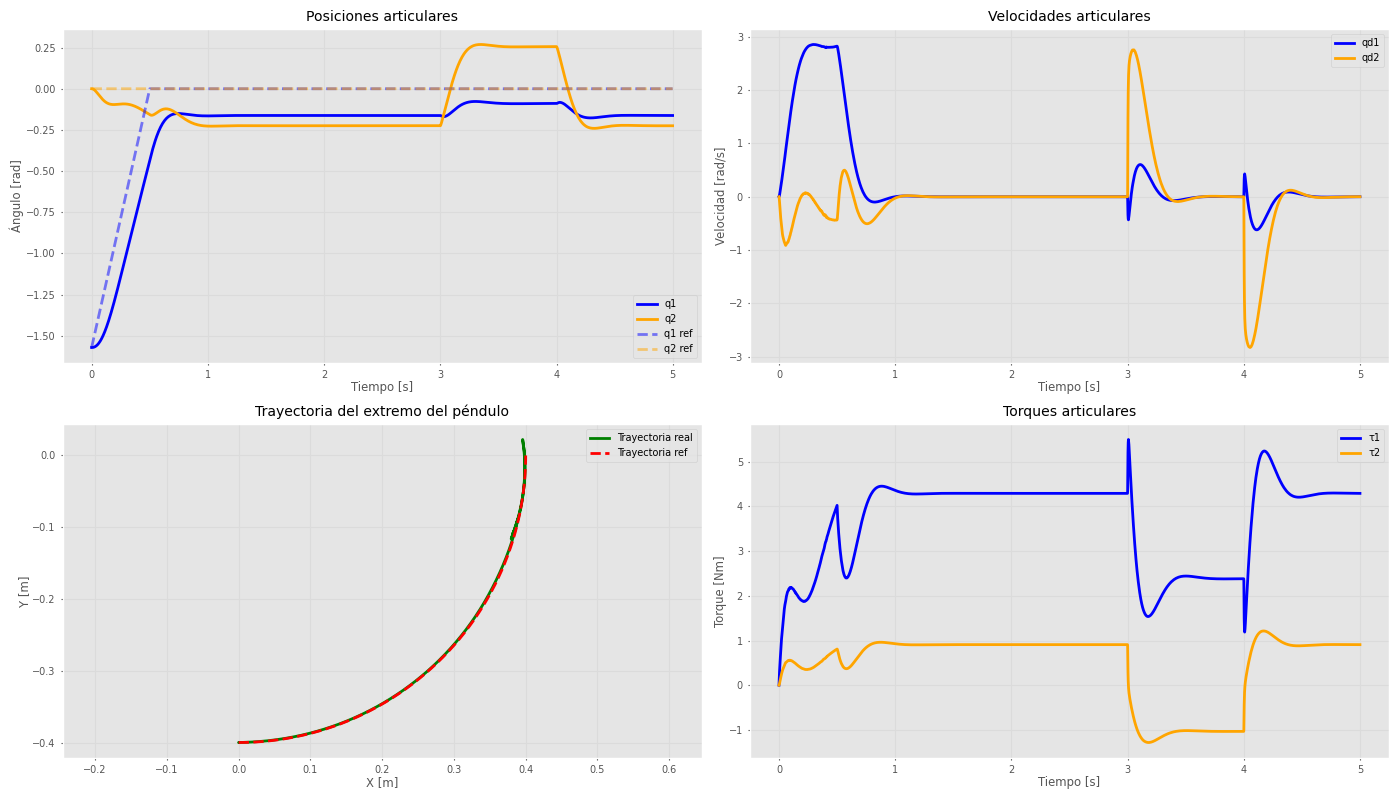

In [151]:
graficar_dinamica(dp,tg.q,tg.qd,tg.t,q_ref,Q_vec)

## Control PD+FF

### Sin perturbacion

✅ Video guardado como 'trayectoria_prueba1_pdFF_NoP.mp4'


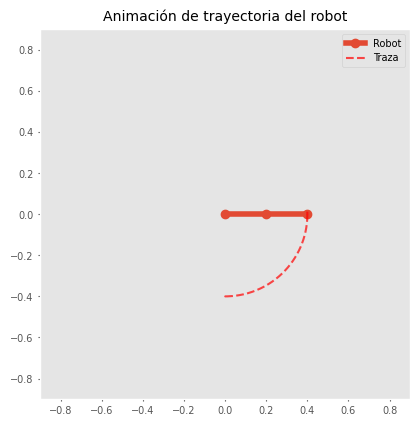

In [ ]:
#--------------------------------------------------------------------
# Torques del controlador
#--------------------------------------------------------------------
Q_vec = np.zeros_like(q_ref)

# -------------------------------------------------------------------
# Controlador PD con compensación de gravedad
# -------------------------------------------------------------------
def pdFF_control(robot, t, q, qd):
    """
    Controlador PD para seguimiento de trayectoria articular con compensación de gravedad.

    Parámetros:
    - robot: objeto robot (no se utiliza directamente aquí)
    - t: tiempo actual (s)
    - q: vector de posiciones articulares actuales
    - qd: vector de velocidades articulares actuales

    Retorna:
    - Q: vector de torques de control
    """
    global kp, kd, q_ref

    step = round(t/dt)

    if step >= q_ref.shape[0]:
        step = q_ref.shape[0]-1

    q_ref_i = q_ref[step]

    # -------------------------------------------------------------------
    # Cálculo del torque gravitacional en la postura de referencia
    # -------------------------------------------------------------------
    # Este término será usado como compensación de feedforward
    # para contrarrestar el efecto de la gravedad en q_ref.
    G = dp.gravload(q_ref_i)


    wn = 30
    # Ganancias proporcionales y derivativas
    kp = (wn**2 * Jef) / (N * km)
    kd = (2 * np.sqrt(N * km * kp * Jef) - Bef) / (N * km)

    # Ley de control PD con compensación de gravedad
    # Q = np.dot(kp, (q_ref - q)) - np.dot(kd, qd) + (1 / (N * km)) * G
    Q1 = kp[0,0] * (q_ref_i[0] - q[0]) - kd[0,0] * qd[0] + (1 / (N * km)) * G[0]
    Q2 = kp[1,1] * (q_ref_i[1] - q[1]) - kd[1,1] * qd[1] + (1 / (N * km)) * G[1]
    Q_act = np.array([Q1,Q2])
    return Q_act

tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T=T,                # T: duración de la simulación en segundos
    q0 = q0,           # q0: posición inicial de las articulaciones
    Q=pdFF_control,        # Q: función que genera el torque en función del estado
    qd0=qd0,  # qd0: velocidad inicial de las articulaciones
    dt=dt           # dt: paso de tiempo de integración
)

# Calculo de Q (si lo sacabmos de la funcion se bugueaba)
for i in range(q_ref.shape[0]):
    Q_vec[i,:] = pdFF_control(dp,tg.t[i],tg.q[i],tg.qd[i])


generar_video_trayectoria(tg.q,nombre_archivo='trayectoria_prueba1_pdFF_NoP.mp4',export_fps=60,sim_dt=tg.t[1]-tg.t[0],l1=l1,l2=l2)

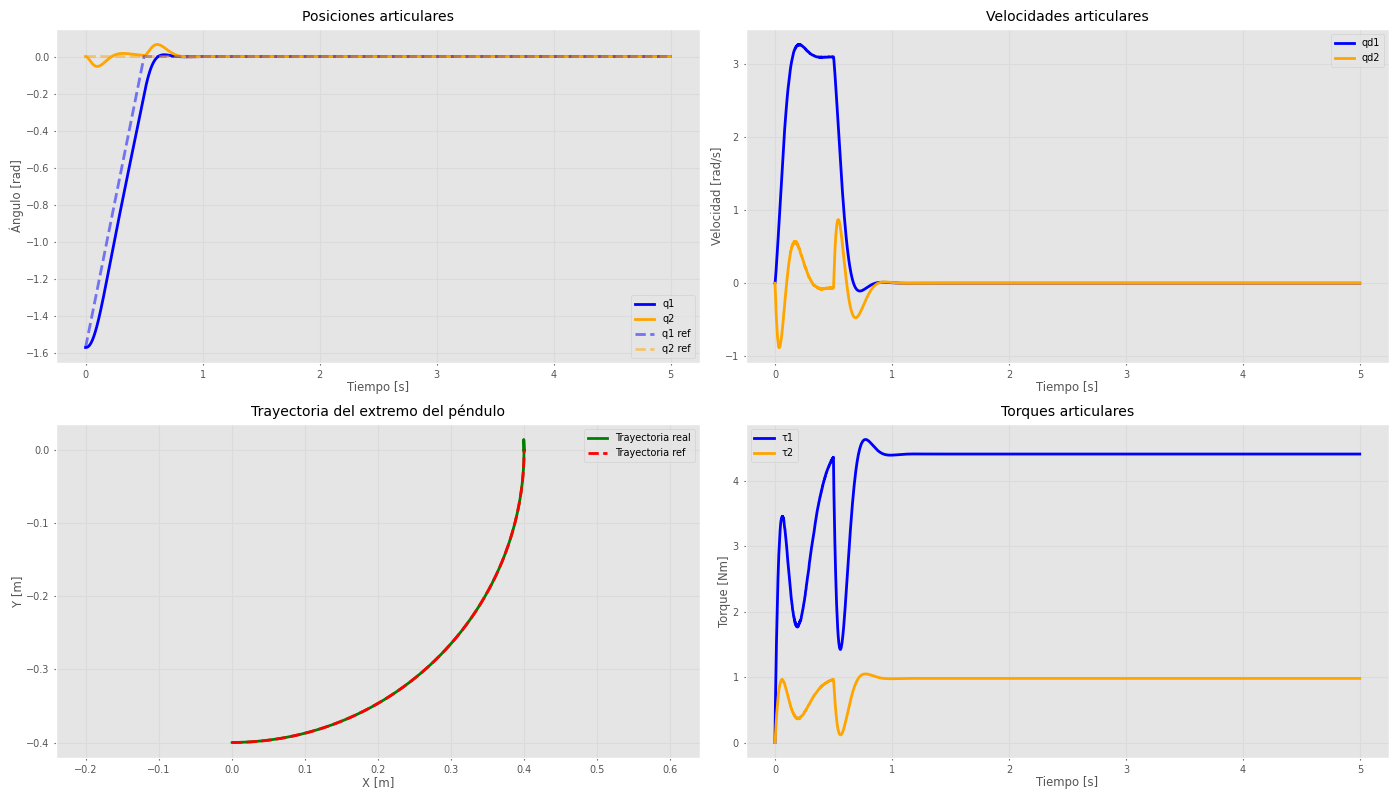

In [153]:
graficar_dinamica(dp,tg.q,tg.qd,tg.t,q_ref,Q_vec)

### Con perturbacion

✅ Video guardado como 'trayectoria_prueba1_pdFF_P.mp4'


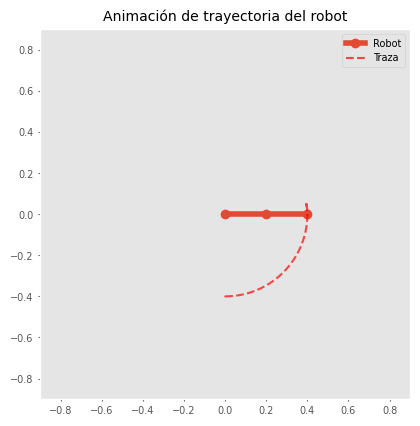

In [ ]:
#--------------------------------------------------------------------
# Torques del controlador
#--------------------------------------------------------------------
Q_vec = np.zeros_like(q_ref)

# -------------------------------------------------------------------
# Controlador PD con compensación de gravedad
# -------------------------------------------------------------------
def pdFF_control_P(robot, t, q, qd):
    """
    Controlador PD para seguimiento de trayectoria articular con compensación de gravedad.

    Parámetros:
    - robot: objeto robot (no se utiliza directamente aquí)
    - t: tiempo actual (s)
    - q: vector de posiciones articulares actuales
    - qd: vector de velocidades articulares actuales

    Retorna:
    - Q: vector de torques de control
    """
    global kp, kd, q_ref

    step = round(t/dt)

    if step >= q_ref.shape[0]:
        step = q_ref.shape[0]-1

    q_ref_i = q_ref[step]

    # -------------------------------------------------------------------
    # Cálculo del torque gravitacional en la postura de referencia
    # -------------------------------------------------------------------
    # Este término será usado como compensación de feedforward
    # para contrarrestar el efecto de la gravedad en q_ref.
    G = dp.gravload(q_ref_i)


    wn = 30
    # Ganancias proporcionales y derivativas
    kp = (wn**2 * Jef) / (N * km)
    kd = (2 * np.sqrt(N * km * kp * Jef) - Bef) / (N * km)

    # Perturbacion:
    tau_p1 = 2 if 3<t<4 else 0
    tau_p2 = 2 if 3<t<4 else 0

    # Ley de control PD con compensación de gravedad
    # Q = np.dot(kp, (q_ref - q)) - np.dot(kd, qd) + (1 / (N * km)) * G
    Q1 = kp[0,0] * (q_ref_i[0] - q[0]) - kd[0,0] * qd[0] + (1 / (N * km)) * G[0] + tau_p1
    Q2 = kp[1,1] * (q_ref_i[1] - q[1]) - kd[1,1] * qd[1] + (1 / (N * km)) * G[1] + tau_p2
    Q_act = np.array([Q1,Q2])

    Q_vec[step] = Q_act
    return Q_act

tg = dp.nofriction(coulomb=True, viscous=False).fdyn(
    T=T,                # T: duración de la simulación en segundos
    q0 = q0,           # q0: posición inicial de las articulaciones
    Q=pdFF_control_P,        # Q: función que genera el torque en función del estado
    qd0=qd0,  # qd0: velocidad inicial de las articulaciones
    dt=dt           # dt: paso de tiempo de integración
)

# Calculo de Q (si lo sacabmos de la funcion se bugueaba)
for i in range(q_ref.shape[0]):
    Q_vec[i,:] = pdFF_control(dp,tg.t[i],tg.q[i],tg.qd[i])

generar_video_trayectoria(tg.q,nombre_archivo='trayectoria_prueba1_pdFF_P.mp4',export_fps=60,sim_dt=tg.t[1]-tg.t[0],l1=l1,l2=l2)

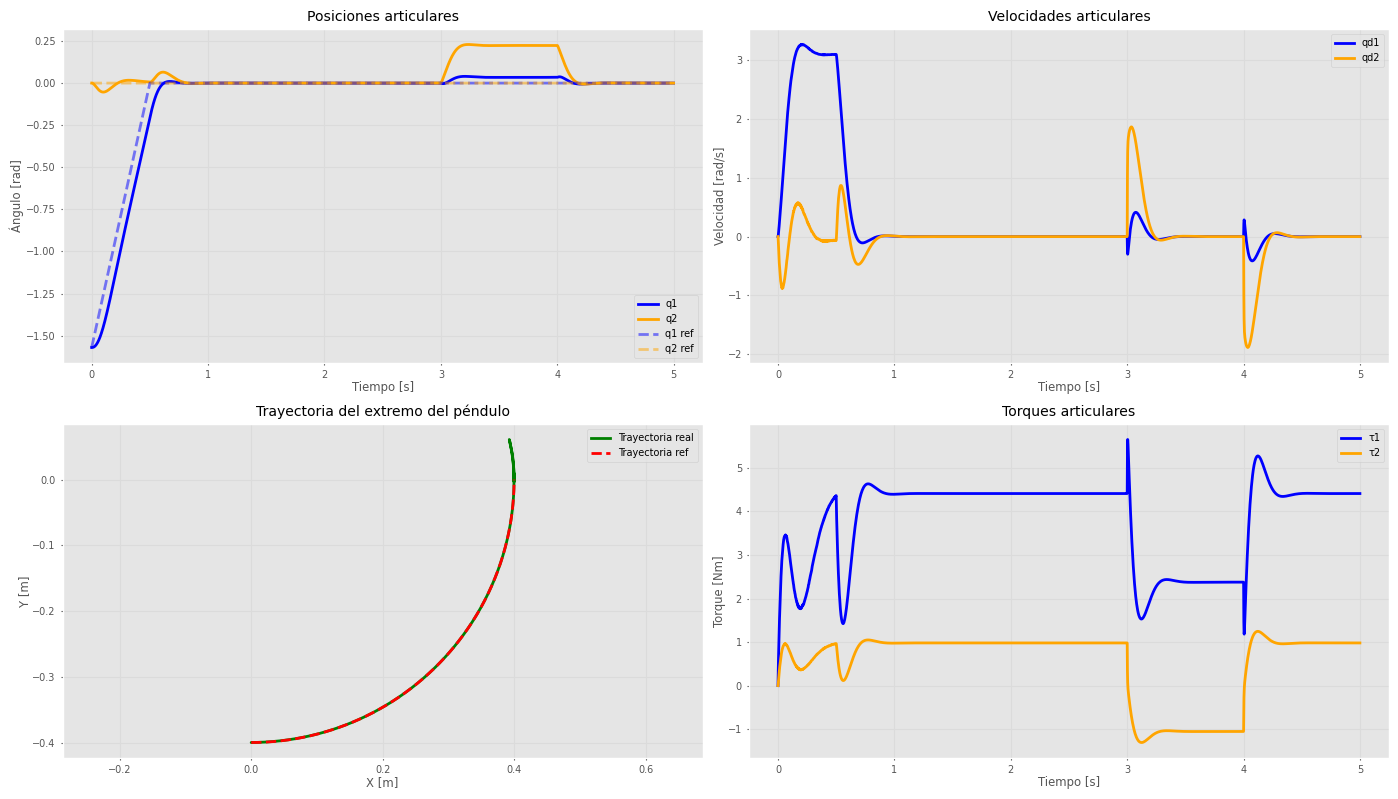

In [155]:
graficar_dinamica(dp,tg.q,tg.qd,tg.t,q_ref,Q_vec)